# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This m

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories,
                                      data_home='~/Desktop/EugeneTang/Grad School/Berkeley/W207_AML/Assignments/Datasets')
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories,
                                     data_home='~/Desktop/EugeneTang/Grad School/Berkeley/W207_AML/Assignments/Datasets')

num_test = len(newsgroups_test.target)
dev_test_split = int(num_test/2)
test_data, test_labels = newsgroups_test.data[dev_test_split:], newsgroups_test.target[dev_test_split:]
dev_data, dev_labels = newsgroups_test.data[:dev_test_split], newsgroups_test.target[:dev_test_split]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
id_to_category = newsgroups_train.target_names
def P1(num_examples=5):
    print('------------------------------')
    for i in range(num_examples):
        print('Label: {}'.format(id_to_category[train_labels[i]]))
        print('Text: {}'.format(train_data[i]))
        print('------------------------------')
P1(5)

------------------------------
Label: comp.graphics
Text: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------------------------------
Label: talk.religion.misc
Text: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
    cv = CountVectorizer()
    train_vectors = cv.fit_transform(train_data)
    
    # a
    num_rows = train_vectors.shape[0]
    vocab_size = train_vectors.shape[1]
    print('a.')
    print('The vocabulary contains {} terms.'.format(vocab_size))
    print('The average number of non-zero features per example is {}.'.format(train_vectors.nnz/num_rows))
    print('The fraction of non-zero entries in the matrix is {}.'.format(train_vectors.nnz/(vocab_size * num_rows)))
    print()

    # b
    feature_names = cv.get_feature_names() # feature names is alphabetical already
    print('b.')
    print('The 0th feature string is {}'.format(feature_names[0]))
    print('The last feature string is {}'.format(feature_names[-1]))
    print()

    # c
    cv_c = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    train_vectors_c = cv_c.fit_transform(train_data)
    num_rows_c = train_vectors_c.shape[0]
    vocab_size_c = train_vectors_c.shape[1]
    print('c.')
    print('Our data contains {} rows and a vocabulary size of {}, as expected.'.format(num_rows_c, vocab_size_c))
    print('The fraction of non-zero entries in the matrix is {}.'.format(train_vectors_c.nnz/(vocab_size_c * num_rows_c)))
    print()
    
    # d
    cv_d = CountVectorizer(analyzer='char', ngram_range=(2,3))
    train_vectors_d = cv_d.fit_transform(train_data)
    vocab_size_d = train_vectors_d.shape[1]
    print('d.')
    print('Our character bigram/trigram data has a vocabulary size of {}.'.format(vocab_size_d))
    print()
    
    # e
    cv_e = CountVectorizer(min_df=10)
    train_vectors_e = cv_e.fit_transform(train_data)
    vocab_size_e = train_vectors_e.shape[1]
    print('e.')
    print('Our data with a minimum document frequency of 10 has a vocabulary size of {}.'.format(vocab_size_e))
    print()    
    
    # f
    cv_dev = CountVectorizer()
    dev_vectors = cv_dev.fit_transform(dev_data)
    
    dev_feature_names = cv_dev.get_feature_names()
    num_missing_words_dev = len(set(dev_feature_names) - set(feature_names))
    num_words_dev = len(dev_feature_names)
    print('f.')
    print('{}% of the words in the dev data are missing from the vocabulary'.format(num_missing_words_dev/num_words_dev*100))
    
P2()

a.
The vocabulary contains 26879 terms.
The average number of non-zero features per example is 96.70599803343165.
The fraction of non-zero entries in the matrix is 0.0035978272269590263.

b.
The 0th feature string is 00
The last feature string is zyxel

c.
Our data contains 2034 rows and a vocabulary size of 4, as expected.
The fraction of non-zero entries in the matrix is 0.06710914454277286.

d.
Our character bigram/trigram data has a vocabulary size of 35478.

e.
Our data with a minimum document frequency of 10 has a vocabulary size of 3064.

f.
24.787640034470023% of the words in the dev data are missing from the vocabulary


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

The optimal value for k in knn is 150.
The f1 score of the optimal knn classifier on the dev data is 0.4423076923076923.

The optimal value for alpha in Multinomial Naive Bayes is 0.01.
The f1 score of the optimal Mulitnomial Naive Bayes classifier on the dev data is 0.7795857988165681.


/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


The optimal value for C in logistic regression is 0.5.
The f1 score of the optimal logistic regression classifier on the dev data is 0.7159763313609467.

Sum of Squared Weights by Value of C
C       | Sum of Squared Weights
--------------------------------
 0.0001 |                   0.04
 0.0010 |                   0.73
 0.0100 |                  10.59
 0.1000 |                 102.27
 0.5000 |                 373.73
 1.0000 |                 601.66
 2.0000 |                 922.25
 5.0000 |                1513.59
10.0000 |                2107.36


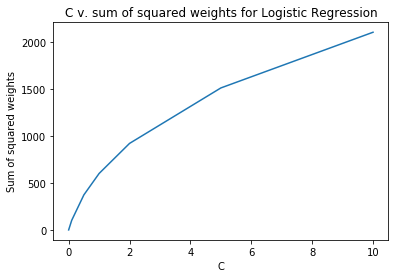

In [5]:
def P3():
    cv = CountVectorizer()
    train_vectors = cv.fit_transform(train_data)
    dev_vectors = cv.transform(dev_data)
    
    f1_metric = 'micro' # caculate the f-score based on num-right v. num-wrong
    
    # Grid-search on KNN. We try nearest neighbors from 1 and[10,300] in intervals of 10
    n_neighbors = [1] + list(range(10,301,10))
    knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': n_neighbors}, scoring='f1_{}'.format(f1_metric))
    knn_grid.fit(train_vectors, train_labels)
    dev_pred_knn = knn_grid.best_estimator_.predict(dev_vectors)
    knn_f1_score = metrics.f1_score(dev_labels, dev_pred_knn, average=f1_metric)
    print('The optimal value for k in knn is {}.'.format(knn_grid.best_params_['n_neighbors']))
    print('The f1 score of the optimal knn classifier on the dev data is {}.'.format(knn_f1_score))
    print()
    
    # Grid-search on Multinomial Naive Bayes. We try alpha in this array: [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    mnb_grid = GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': alphas}, scoring='f1_{}'.format(f1_metric))
    mnb_grid.fit(train_vectors, train_labels)
    dev_pred_mnb = mnb_grid.best_estimator_.predict(dev_vectors)
    mnb_f1_score = metrics.f1_score(dev_labels, dev_pred_mnb, average=f1_metric)
    print('The optimal value for alpha in Multinomial Naive Bayes is {}.'.format(mnb_grid.best_params_['alpha']))
    print('The f1 score of the optimal Mulitnomial Naive Bayes classifier on the dev data is {}.'.format(mnb_f1_score))
    
    # Grid-search on logistic regression with l2 regularization. We try the following values for C: [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    Cs = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    lr_grid = GridSearchCV(estimator=LogisticRegression(), param_grid={'C': Cs}, scoring='f1_{}'.format(f1_metric))
    lr_grid.fit(train_vectors, train_labels)
    dev_pred_lr = lr_grid.best_estimator_.predict(dev_vectors)
    lr_f1_score = metrics.f1_score(dev_labels, dev_pred_lr, average=f1_metric)
    print('The optimal value for C in logistic regression is {}.'.format(lr_grid.best_params_['C']))
    print('The f1 score of the optimal logistic regression classifier on the dev data is {}.'.format(lr_f1_score))
    print()
    
    # Find and plot sum of squared weights v. C
    print('Sum of Squared Weights by Value of C')
    print('C       | Sum of Squared Weights')
    print('--------------------------------')
    sum_of_squared_weights = []
    for c in Cs:
        lr = LogisticRegression(C=c)
        lr.fit(train_vectors, train_labels)
        coef_squared_sum = float(np.sum(np.square(lr.coef_)))
        sum_of_squared_weights.append(coef_squared_sum)
        print('{:7.4f} | {:22.2f}'.format(c, coef_squared_sum))
    
    plt.plot(Cs, sum_of_squared_weights)
    plt.title("C v. sum of squared weights for Logistic Regression")
    plt.xlabel("C")
    plt.ylabel("Sum of squared weights")
    plt.show()
P3()

ANSWER:


a. Nearest neighbors doesn't work well for this problem because different texts in the same category will still use different words, even if those words are close in meaning. Thus a high "distance" can be misleading in this space. (e.g. if one document says "religion is bad", and the other says "I like Christianity", they will be seen as having no overlap even though they talk about very similar things.). Also, the default KNN uses Euclidean distance, so the length of the document could also influence the perceived "distances" (longer documents will be more likely to be "far" away from each other).


b. Because Naive Bayes tries to estimate probabilities that a word appears in a document of a given category and evaluates each word ("feature") independently, it likely requires less data to provide a decent estimate. On the other hand, in this case logistic regression may do worse because the words are in reality dependent on each other, and so it may take more data to find good coefficients.


c. From the output above, we can see that the sum of the squared weights generally increase with C. This makes sense because a lower value of C penalizes higher weights more. (C is the inverse of regularization strength). The sum of squared weights seem to increase logarithmically with C.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
def train_models(cv_ngram_range):
    # Same as above except using bigram features
    cv = CountVectorizer(ngram_range=cv_ngram_range)
    train_vectors = cv.fit_transform(train_data)
    print('Number of features: {}'.format(train_vectors.shape[1]))
    
    # Use gridsearch to find best value of C
    Cs = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    lr_grid = GridSearchCV(estimator=LogisticRegression(), param_grid={'C': Cs}, scoring='f1_micro')
    lr_grid.fit(train_vectors, train_labels)
    print('The best value of C found was: {}'.format(lr_grid.best_params_['C']))
    return (cv, lr_grid.best_estimator_)

def print_top_5_features(cv, lr):
    # Print out top 5 weighted features (not in absolute value: top features that indicate that a category is present)  
    top_feature_indices = []

    # Get top features
    for i in range(len(newsgroups_train.target_names)):
        top_feature_indices += lr.coef_[i].argsort()[-5:].tolist()
    
    # Print table
    print('Word         | Weight for Atheism | Weight for Computer Graphics | Weight for Space | Weight for Religion')
    print('---------------------------------------------------------------------------------------------------------')
    feature_names = cv.get_feature_names()
    for feature_index in top_feature_indices:
        # get feature name
        table_entries = [feature_names[feature_index]] 
        # add feature weights for each category
        table_entries += [lr.coef_[i][feature_index] for i in range(len(newsgroups_train.target_names))]
        print('{:12s} | {:18.6f} | {:28.6f} | {:16.6f} | {:19.6f}'.format(*table_entries))
        
def P4():
    print('--Unigram logistic regression model--')
    cv, lr = train_models((1,1))
    print('Top features for each category with a unigram tokenizer')
    print_top_5_features(cv, lr)
    
    print()
        
    # Same as above except using bigram features
    print('--Bigram logistic regression model--')
    cv_bigram, lr_bigram = train_models((2,2))
    print('Top features for each category with a bigram tokenizer')
    print_top_5_features(cv_bigram, lr_bigram)
     
P4()

--Unigram logistic regression model--
Number of features: 26879
The best value of C found was: 0.5
Top features for each category with a unigram tokenizer
Word         | Weight for Atheism | Weight for Computer Graphics | Weight for Space | Weight for Religion
---------------------------------------------------------------------------------------------------------
deletion     |           0.723524 |                    -0.249531 |        -0.272433 |           -0.270263
atheism      |           0.794488 |                    -0.348444 |        -0.367204 |           -0.377076
religion     |           0.798243 |                    -0.508671 |        -0.658825 |           -0.050695
bobby        |           0.823571 |                    -0.191204 |        -0.286357 |           -0.387236
atheists     |           0.833600 |                    -0.093277 |        -0.267655 |           -0.637544
computer     |           0.071498 |                     0.843819 |        -0.569566 |           -0.3962

ANSWER: 


For the unigram classifier, we see that the top features for each category are words that we would expect to associate with the category (e.g. "nasa" and "orbit" with Space, and "image" and "graphics" with Computer Graphics). Some of the top unigram features are a little bit surprising (e.g. "fbi" for Religion and "deletion", "bobby" for Atheism), but overall they make sense. The presense of stranger words could be the result of the content of the sample documents (e.g. fbi investigations into religious organizations, an influential athiest named Bobby). One nice characteristic we can observe about the top features is that the top features in one category generally have negative weights in the other categories. For example, "nasa" has a weight of 0.85 for the "space" category while having a fairly negative weight (-0.4) in all other categories.


For the bigrams features, we do have some surprising top features. Some features (e.g. "the moon" and "comp graphics") make sense, while others seem a bit strange. For example, in Atheism "was just" and "you are" show up as top features, which is quite unexpected. In general, a lot of very generic phrases ("is there", "out there", "was just") carry a surprisingly high weights, implying that the bigram classifier is likely overfitting (there are many more features (195k) than training examples). Additionally, certain phrases seem very specific (e.g. "sherzer methodology", which only appears in two training documents). While these phrases may be useful in identifying the topic, the fact that such phrases appear as top features make me question whether what the bigram regression is learning is generalizable.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
def empty_preprocessor(s):
    return s

import nltk
from nltk.corpus import stopwords
RE_NUMBER = re.compile(r'\b(([-+]?(\d*[,.\d]+\d))|(\d+))\b') # regex to capture numbers; also tries to catch forms e.g. 1.23, 1,000.
RE_PUNC = re.compile(r'[^\s\w\']+') # punctuation = non-whitespace / non-alphanumeric characters
RE_WHITESPACE = re.compile(r'\s+') # whitespace
STEMMER = nltk.stem.PorterStemmer()
STOPWORDS = stopwords.words('english')
def better_preprocessor(s):
    # lowercase the string
    s = s.lower()
    
    # replace numbers
    s = RE_NUMBER.sub(' _NUM_ ', s)
    
    # replace non-alphanumeric characters with a space
    s = RE_PUNC.sub(' ', s)
    
    # normalize whitespace
    s = RE_WHITESPACE.sub(' ', s)

    # stem words & remove stopwords (including words that are too "short")
    s = ' '.join([STEMMER.stem(w) for w in s.split() if w not in STOPWORDS and len(w) > 2])
    
    return s

def run_logistic_regression(preprocessor):
    # Vectorize
    cv = CountVectorizer()
    train_vectors = cv.fit_transform([preprocessor(s) for s in train_data])
    dev_vectors = cv.transform([preprocessor(s) for s in dev_data])
    print('Vocabulary size: {}'.format(train_vectors.shape[1]))
    
    # Train & use gridsearch to find best value of C
    Cs = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    lr_grid = GridSearchCV(estimator=LogisticRegression(), param_grid={'C': Cs}, scoring='f1_micro')
    lr_grid.fit(train_vectors, train_labels)
    print('The best value of C found was: {}'.format(lr_grid.best_params_['C']))
    
    # Evaluate
    dev_pred = lr_grid.best_estimator_.predict(dev_vectors)
    f1_score = metrics.f1_score(dev_labels, dev_pred, average='micro')
    print('f1 score on dev data: {}.'.format(f1_score))
    

def P5():
    # No preprocessing
    print('--Results with no preprocessing--')
    run_logistic_regression(empty_preprocessor)
    print()
    
    # Some preprocessing
    print('--Results with some preprocessing--')
    run_logistic_regression(better_preprocessor)
    print()

P5()

--Results with no preprocessing--
Vocabulary size: 26879
The best value of C found was: 0.5
f1 score on dev data: 0.7159763313609467.

--Results with some preprocessing--
Vocabulary size: 17939
The best value of C found was: 0.1
f1 score on dev data: 0.7366863905325444.



Our preprocessing improves the f1 score on the dev data by ~2.1 points and reduces the dictionary size from 26,879 elements to 17,939 elements. We use nltk to help get a list of stopwords and access to the Porter Stemmer to reduce words to their base form.

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Vocabulary size: 26879

Training logistic regression with model with l2 penalty
The best value of C found was: 0.5
f1 score on dev data: 0.7159763313609467.

Training logistic regression with model with l1 penalty
The best value of C found was: 2.0
f1 score on dev data: 0.6967455621301775.

The model trained with l2 penalty has 107516 nonzero coefficients
The model trained with l1 penalty has 2243 nonzero coefficients
The model trained with l1 penalty has 1363 unique terms that have at least one nonzero coefficient

Training logistic regression with model with l2 penalty and modified vocabulary
The best value of C found was: 0.5
f1 score on dev data: 0.6863905325443787.

Vocab sizes: [2, 17, 207, 728, 1102, 1530, 2543, 5835]
F1 scores: [0.3668639053254438, 0.48668639053254437, 0.6878698224852071, 0.6804733727810651, 0.6789940828402367, 0.6967455621301775, 0.6937869822485208, 0.6937869822485208]


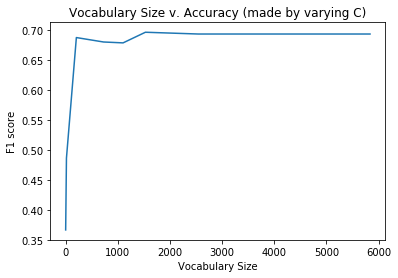

In [8]:
# train and return a logistic regression model with the given penalty
def train_and_return_model(train_vectors, dev_vectors, penalty):
    # Train & use gridsearch to find best value of C
    Cs = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    lr_grid = GridSearchCV(estimator=LogisticRegression(penalty=penalty), param_grid={'C': Cs}, scoring='f1_micro')
    lr_grid.fit(train_vectors, train_labels)
    print('The best value of C found was: {}'.format(lr_grid.best_params_['C']))
    
    # Evaluate
    dev_pred = lr_grid.best_estimator_.predict(dev_vectors)
    f1_score = metrics.f1_score(dev_labels, dev_pred, average='micro')
    print('f1 score on dev data: {}.'.format(f1_score))
    print()
    
    return lr_grid.best_estimator_

# sum the number of nonzero coefficients across all categories
def get_num_nonzero_coefs(lr):
    num_nonzero_coefs = 0
    for i in range(len(newsgroups_train.target_names)):
        coefs = lr.coef_[i]
        num_nonzero_coefs += len(coefs[np.nonzero(coefs)])
    return num_nonzero_coefs

# get the elements with nonzero weights
def get_vocab_with_nonzero_weights(cv, lr):
    nonzero_coefs_indices = set()
    for i in range(len(newsgroups_train.target_names)):
        coefs = lr.coef_[i]
        nonzero_coefs_indices |= set(np.nonzero(coefs)[0].tolist())
    feature_names = cv.get_feature_names()
    return [feature_names[int(i)] for i in list(nonzero_coefs_indices)]

# plot vocabulary size v. accuracy 
def plot_vocab_size_and_accuracy(cv, train_vectors, dev_vectors):
    Cs = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 50.0]
    vocab_sizes = []
    f1_scores = []
    for C in Cs:
        # Train l1 regression
        lr = LogisticRegression(C=C, penalty='l1', tol=0.01)
        lr.fit(train_vectors, train_labels)
        l1_vocab = get_vocab_with_nonzero_weights(cv, lr)
        
        # Train l2 regression with new vocab with gridsearch
        cv2 = CountVectorizer(vocabulary=l1_vocab)
        train_vectors2 = cv2.fit_transform(train_data)
        dev_vectors2 = cv2.transform(dev_data)
        lr_grid = GridSearchCV(estimator=LogisticRegression(penalty='l2', tol=0.01), param_grid={'C': Cs}, scoring='f1_micro')
        lr_grid.fit(train_vectors2, train_labels)
    
        # Evaluate
        dev_pred = lr_grid.best_estimator_.predict(dev_vectors2)
        f1_scores.append(metrics.f1_score(dev_labels, dev_pred, average='micro'))
        vocab_sizes.append(len(l1_vocab))
    
    print('Vocab sizes:', vocab_sizes)
    print('F1 scores:', f1_scores)
    
    plt.plot(vocab_sizes, f1_scores)
    plt.title('Vocabulary Size v. Accuracy (made by varying C)')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('F1 score')
    plt.show()

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    # Vectorize
    cv = CountVectorizer()
    train_vectors = cv.fit_transform(train_data)
    dev_vectors = cv.transform(dev_data)
    print('Vocabulary size: {}'.format(train_vectors.shape[1]))
    print()
    
    # train models
    print('Training logistic regression with model with l2 penalty')
    l2_model = train_and_return_model(train_vectors, dev_vectors, 'l2')

    print('Training logistic regression with model with l1 penalty')
    l1_model = train_and_return_model(train_vectors, dev_vectors, 'l1')

    # print number of nonzero coefficients
    print('The model trained with l2 penalty has {} nonzero coefficients'.format(get_num_nonzero_coefs(l2_model)))
    print('The model trained with l1 penalty has {} nonzero coefficients'.format(get_num_nonzero_coefs(l1_model)))
    
    # keep features with at least one nonzero weight
    l1_vocab = get_vocab_with_nonzero_weights(cv, l1_model)
    print('The model trained with l1 penalty has {} unique terms that have at least one nonzero coefficient'.format(len(l1_vocab)))
    print()
    
    # retrain an l2 model with the new vocabulary
    cv2 = CountVectorizer(vocabulary=l1_vocab)
    train_vectors2 = cv2.fit_transform(train_data)
    dev_vectors2 = cv2.transform(dev_data)
    print('Training logistic regression with model with l2 penalty and modified vocabulary')
    train_and_return_model(train_vectors2, dev_vectors2, 'l2')
    
    # plot vocabulary size v. accuracy by varying C
    plot_vocab_size_and_accuracy(cv, train_vectors, dev_vectors)
    
    
    
P6()

ANSWER: The number of nonzero weights when we use the l1 penalty is significantly less than the number of nonzero weights when we use the l2 penalty (almost 10x fewer). Overall, the model trained with l1 penalty has 719 unique terms (if we take them across the entire dataset). In the chart, we can see that while we get a large jump in f1 as the vocabulary increases from 2 to 207, but then after that the adding more vocabulary only increases the accuracy by a small amount.

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [9]:
def P7():
    tv = TfidfVectorizer()
    train_vectors = tv.fit_transform(train_data)
    dev_vectors = tv.transform(dev_data)
    
    # Train
    lr = LogisticRegression(C=100)
    lr.fit(train_vectors, train_labels)
    
    # Evaluate
    dev_pred = lr.predict(dev_vectors)
    f1_score = metrics.f1_score(dev_labels, dev_pred, average='micro')
    print('The f1 score using the tfidf vectorizer is {}'.format(f1_score))
    print()
    
    # find top three Rs
    dev_pred_probas = lr.predict_proba(dev_vectors)
    Rs = []
    for i in range(len(dev_pred_probas)):
        max_pred_label = np.argmax(dev_pred_probas[i])
        true_label = dev_labels[i]
        max_pred_prob = dev_pred_probas[i][max_pred_label]
        true_pred_prob = dev_pred_probas[i][true_label]
        R = max_pred_prob / true_pred_prob
        Rs.append(R)
    top_R_indices = np.array(Rs).argsort()[-3:].tolist()
    
    print('The top three mistakes are:')
    for i in reversed(top_R_indices):
        print('-------------------')
        print('R: {}'.format(Rs[i]))
        print('Predicted Label: {}'.format(id_to_category[np.argmax(dev_pred_probas[i])]))
        print('True Label: {}'.format(id_to_category[dev_labels[i]]))
        print()
        print(dev_data[i])
        print()
        
P7()

The f1 score using the tfidf vectorizer is 0.7633136094674556

The top three mistakes are:
-------------------
R: 929.3574262493551
Predicted Label: comp.graphics
True Label: talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), bu

ANSWER: The tfidf vectorizer is different from the count vectorizer because it weights each term based on the term's "importance", which is defined as a combination of how often the term appears in the document and how many documents the term appears in. The more times a term appears in a document, the more "important" of a feature it is. The more documents a term appears in, the less "important" of a feature it is because it is likely just a common word. This is different from count vectorization, because in some sense, count vectorization only takes into account how often the term appears in the document. 


Going through some of the example mistakes, I see two common mistakes happening. The first is that the classifier mixes up atheism and religion. This is not too surprising given that the two topics will often discuss the other. The second is that sometimes certain words will trigger "space" (e.g. "universe") or "graphics" (e.g. "ftp"), even if the document is clearly not talking about that topic. One way to try to address this is to impose a limit on the maximum possible weight of a term. Another way we can try to address this is to impose a minimum document frequency (only allow words that appear more than n times to avoid rare words having too high of a weight) and preprocessing the text (this would allow words of similar meaning to be grouped together). 

To try to address the classifier mixing up atheism and religion, we could try weighting the two groups higher than the other groups so that the classifier tries harder not to mix them up.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [10]:
def P8():
    Cs = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 100.0]
    
    # documents must show up in at least 2 documents
    tv = TfidfVectorizer(min_df=2)
    train_vectors = tv.fit_transform(train_data)
    dev_vectors = tv.transform(dev_data)
    
    # Train with gridsearch
    lr_grid = GridSearchCV(estimator=LogisticRegression(penalty='l2', tol=0.01), param_grid={'C': Cs}, scoring='f1_micro')
    lr_grid.fit(train_vectors, train_labels)
    print('The best value of C found was: {}'.format(lr_grid.best_params_['C']))
    
    # Evaluate
    dev_pred = lr_grid.best_estimator_.predict(dev_vectors)
    f1_score = metrics.f1_score(dev_labels, dev_pred, average='micro')
    print('The f1 score using the tfidf vectorizer is {}'.format(f1_score))
    print()
        
P8()

The best value of C found was: 100.0
The f1 score using the tfidf vectorizer is 0.7736686390532546



In this section I tried a couple of things (preprocessing the text, changing the class weights in the logistic regression ("class_weight={0:2,1:1,2:1,3:2}"), changing the value of C). In the end I found that the changes above were the most effective and improved the f1 score with tfidf from 0.763 to 0.774.